<a href="https://colab.research.google.com/github/skfkeh/runStockForAI/blob/main/runStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사용방법
1. 분석하길 원하는 패턴을 선택한다.<br>
  (1: 코스피/코스닥 전체, 2: 특정 종목만(엑셀 필요), 3: 테마별)
2. 패턴 선택
  *   패턴 1 선택 시, 아래 셀에서 '1'로 넣는다.
  *   패턴 2 선택 시, 아래 셀에서 '2'로 넣고 종목을 엑셀파일로 만들어 놓는다.
  <br>양식은 다음과 같음.<br>
   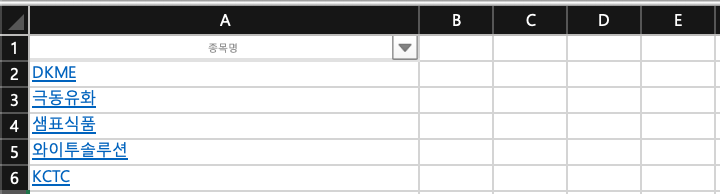
  *   패턴 3 선택 시, 아래 셀에서 '3'로 넣는다. -> 준비 중
2. 좌측탭 메뉴의 "폴더" 아이콘을 클릭하여, 만들어둔 엑셀파일을 업로드한다.
3. 업로드한 파일의 경로(path)를 복사하여, 아래 셀에 붙여넣는다.
4. 경로를 붙여넣었다면 상단 메뉴탭에 잇는 "모두 실행"을 눌러 전체 실행을 한다.

In [ ]:
#### 원하는 패턴을 ▼ 여기에 숫자로 입력해주세요!!!
pattern =       1
##### 입력한 엑셀파일의 경로를 여기 ▼▼▼ 작은따옴표('') 안에 넣어주세요!!!
filePath = '/content/자동화댕 돌리기.xlsx'

In [ ]:
####################
## 0.선언부        ##
####################
## dart 정보 가져오기
## 참고 사이트
## https://dart-fss.readthedocs.io/en/latest/dart_api.html
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import math
import time

start = time.time() ## 시작시점

!pip install dart-fss --quiet

## 하이퍼링크 추가용
!pip install XlsxWriter --quiet

import dart_fss as dart
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [ ]:
####################
## 1.조회 종목 설정  ##
####################

## html 태그 제거하는 function
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html).replace('[','').replace(']','').replace(',','')
  return cleantext

## excel file 읽어오는 function
def read_excel(file_path):
    # excel 파일을 읽어 조회대상 기업을 리스트화
    df = pd.read_excel(file_path, header=None)
    # print(df.head())
    return df.iloc[:, 0]

def getStockListFromNaver():
    headers = {'User-Agent': 'Mozilla/5.0'}

    stock_list = []

    for stockInfo in range(2):
      if   stockInfo == 0: print(' $$$ 코스피 조회 시작 $$$ ')
      elif stockInfo == 1: print(' @@@ 코스닥 조회 시작 @@@ ')
#######
#######   코스닥 확인 필요 / ex, 16페이지, 참좋은여행 or 옵투스제약 등 안나옴
#######
      for page in range(1,50):
        URL = f'https://finance.naver.com/sise/sise_market_sum.naver?sosok={stockInfo}&page={page}'
        response = requests.get(URL, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')

        ### 페이지 시작 및 확인
        pageChk = 0
        if (page%10) == 0: print('')
        print('page[' + str(page) + ']', end=" \t ")

        for i in range(2, 80):
          stockName = soup.select(f'#contentarea > div.box_type_l > table.type_2 > tbody > tr:nth-child({i}) > td:nth-child(2) > a')
          stockName = cleanhtml(str(stockName))
          stockTotalPrise = soup.select(f'#contentarea > div.box_type_l > table.type_2 > tbody > tr:nth-child({i}) > td:nth-child(7)')
          stockTotalPrise = cleanhtml(str(stockTotalPrise))

          if (stockName != '') or (stockTotalPrise != ''):
            ### 조회 중
            pageChk += 1
            # print(f'{stockName}: {stockTotalPrise} $$ {pageChk}')

            ### 시가총액 100~1100억 사이만 가져오면
            if (int(stockTotalPrise) >= 100) and (int(stockTotalPrise) <= 1100):
              stock_list.append(stockName) #(, stockTotalPrise)) # 시가총액까지 담는건 불필요

        ## 조회하는게 없으면 종료
        if pageChk == 0:
          if   stockInfo == 0: print('\n $$$ 코스피 조회 종료 $$$ ')
          elif stockInfo == 1: print('\n @@@ 코스닥 조회 종료 @@@ ')
          break

    return stock_list

In [ ]:
corp_list = []
if pattern == 1:
  corp_list = getStockListFromNaver()

In [ ]:
corp_list = []
if pattern == 1:
  corp_list = getStockListFromNaver()
elif pattern == 2:
  corp_list = read_excel(filePath)

print('조회 종목 수 : ' + str(len(corp_list)))

In [ ]:
#######################
## 2.dart 정보 조회하기 ##
#######################

# API 키 설정 (개발자 포털에서 발급받은 키로 교체)
api_key = '34862215a48286de874cbf0fee6ffbbecb793b24'
dart.set_api_key(api_key=api_key)

def check_capital_changes(start_date: str, end_date: str, corp_codes: list = None):
    """
    유상증자/무상감자 공시 확인 함수
    :param start_date: 검색 시작일 (YYYYMMDD)
    :param end_date: 검색 종료일 (YYYYMMDD)
    :param corp_codes: 특정 기업 검색시 사용(8자리 corp_code 리스트)
    :return: 검색 결과 DataFrame
    """
    # 공시 검색 조건 설정
    search_params = {
        'bgn_de': start_date,
        'end_de': end_date,
        # 'pblntf_detail_ty': ['A001', 'A002', 'A003'],  # 사업/반기/분기 보고서
        'page_count': 100  # 최대 100건까지 조회
    }

    if corp_codes:
        search_params['corp_code'] = corp_codes

    # 공시 검색 실행
    results = dart.filings.search(**search_params)

    # 결과 필터링
    capital_changes = []
    keywords = ['유상증자','무상감자','단기차입금','전환사채','교환사채','신주인수권부사채','전환청구권','교환청구권','부적정','채무보증','담보제공','횡령','배임','단기과열종목','금전대여']

    for report in results.report_list:
        if any(keyword in report.report_nm for keyword in keywords):
            capital_changes.append({
                # '회사명': report.corp_name,
                # '종목코드': report.corp_code,
                '공시일': report.rcept_dt,
                '보고서명': report.report_nm
            })
    return pd.DataFrame(capital_changes)
    # return capital_changes['공시일']+' / '+capital_changes['보고서명']

In [ ]:
#############################################
## 3.종목코드를 가져오기 위해 한국거래소 정보 조회하기 ##
#############################################

chk_code = []

## 한국거래소 data import하여 상장된 기업의 종목 정보 가져오기
def fetch_krx_list():
    """
    한국거래소 KIND에서 상장회사 리스트 (회사명, 종목코드, 상장일) 가져오기
    """
    url = "https://kind.krx.co.kr/corpgeneral/corpList.do?method=download"
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    # 경고 무시
    # 이 옵션을 주석처리하면 종목코드와 상장일 col에서 경고 발생
    pd.set_option('mode.chained_assignment',  None)

    # response.text로 html을 읽고 pandas로 테이블 파싱
    tables = pd.read_html(response.text)
    df = tables[0]  # 첫 번째 테이블이 우리가 원하는 데이터

    # 필요한 열만 추리기
    df = df[['회사명', '종목코드']]

    # try:
    #   df['종목코드'] = df['종목코드'].apply(lambda x: f'{int(x):06d}')  # 종목코드 6자리 문자열
    # except:
    #   chk_code.append(df)
      # print('!!!!! ' + df['회사명'] + '(' + df['종목코드'] + ') 종목코드 확인 필요')
    # df['상장일'] = pd.to_datetime(df['상장일']).dt.strftime('%Y-%m-%d')  # 상장일 포맷 정리

    return df

In [ ]:
## 항목 구분 체크 function
def check_stock_info(chk_var, chk_li):
  if chk_var == 'f':
    if float(chk_li) > 200.0:
      return False
  else:
    if (i > 0 for i in chk_li):
      return False
  return True

## main에서도 사용하기 위해 전역변수로 변경
now = datetime.now()

###############################
## 5.네이버 증권에서 종목정보 크롤링 ##
###############################
def get_stock_info(code):
  # 회사 이름 URL 인코딩
  url = f"https://finance.naver.com/item/main.nhn?code={code}"
  headers = {
      "User-Agent": "Mozilla/5.0"
  }

  response = requests.get(url, headers=headers)
  response.encoding = 'euc-kr'
  soup = BeautifulSoup(response.text, 'html.parser')
  err_list = []
  # 검색 결과 영역에서 주식 링크 찾기 (종목 코드 포함된 링크 찾기)
  link_tag = soup.select_one('#content > div.section.cop_analysis > div.sub_section > table > tbody')
  try:
      link_tag_li = link_tag.find_all("tr")
  except:
      link_tag_li = 'NA'
      err_list.append(str(code) + '_link')

  main_li = []  # 전체 output용
  title_li = [] # 파트 타이틀
  a_li = [] # 매출액
  b_li = [] # 영업이익
  c_li = [] # 당기순이익
  d_li = [] # 현재가
  e_li = [] # 재무제표 결과
  f_li = [] # 부채비율
  h_li = [] # 52주간 최고가
  g_li = [] # 최고가 대비
  i_li = [] # 특이사항
  j_li = [] # 시가총액

  # 내용 담는 용도
  tmp_a_li = []
  tmp_b_li = []
  tmp_c_li = []
  tmp_d_li = []
  tmp_e_li = []
  tmp_f_li = []
  tmp_g_li = []
  tmp_i_li = []

  for i in range(3):
    try:
      tmp_a_li.append(cleanhtml(link_tag_li[0].find_all('td')[i].text).replace('\n', '').replace('\t', '').replace(',', '')) if cleanhtml(link_tag_li[0].find_all('td')[i].text).replace('\n', '').replace('\t', '').replace(',', '') != '' else tmp_a_li.append('NA')
      tmp_b_li.append(cleanhtml(link_tag_li[1].find_all('td')[i].text).replace('\n', '').replace('\t', '').replace(',', '')) if cleanhtml(link_tag_li[1].find_all('td')[i].text).replace('\n', '').replace('\t', '').replace(',', '') != '' else tmp_b_li.append('NA')
      tmp_c_li.append(cleanhtml(link_tag_li[2].find_all('td')[i].text).replace('\n', '').replace('\t', '').replace(',', '')) if cleanhtml(link_tag_li[2].find_all('td')[i].text).replace('\n', '').replace('\t', '').replace(',', '') != '' else tmp_c_li.append('NA')
      tmp_f_li.append(cleanhtml(link_tag_li[6].find_all('td')[i].text).replace('\n', '').replace('\t', '').replace(',', '')) if cleanhtml(link_tag_li[6].find_all('td')[i].text).replace('\n', '').replace('\t', '').replace(',', '') != '' else tmp_f_li.append('NA')
    except:
      # print('!!!!!!!' + code)
      err_list.append(str(code))
      tmp_a_li.append('NA')
      tmp_b_li.append('NA')
      tmp_c_li.append('NA')
      tmp_f_li.append('NA')

  a_li.append(tmp_a_li) # 매출액
  b_li.append(tmp_b_li) # 영업이익
  c_li.append(tmp_c_li) # 당기순이익

  # 시가총액
  try:
      tmp_j_li = cleanhtml(soup.select_one('#_market_sum').text).strip().replace('\n', '').replace('\t', '').replace(',', '').replace('조', '')
  except:
      tmp_j_li = 'NA'
  j_li.append(tmp_j_li)

  # 종목 현재가
  try:
      tmp_d_li = cleanhtml(soup.select_one('#rate_info_krx > div > p.no_today > em.X > span.blind').text)
  except:
      try:
        tmp_d_li = cleanhtml(soup.select_one('#rate_info_krx > div > p.no_today > em.no_up > span.blind').text)
      except:
        try:
          tmp_d_li = cleanhtml(soup.select_one('#rate_info_krx > div > p.no_today > em.no_down > span.blind').text)
        except:
          tmp_d_li = 'NA'
          err_list.append(str(code) + '_now')
  d_li.append(tmp_d_li) # 현재가

  ############# 52주 최고가 왼쪽 : 재무제표 = 매출액, 영업이익, 당기순이익 모두 >0 & 부채비율<200
  chk_stock_status_val = 0
  for a in tmp_a_li:
    try:
      if a == 'NA' or a == '-' or a == '':
        break
      chk_stock_status_val += 1 if int(a) <= 0 else 0
    except:
      chk_stock_status_val += 1
  for b in tmp_b_li:
    try:
      if b == 'NA' or b == '-' or b == '':
        break
      chk_stock_status_val += 1 if int(b) <= 0 else 0
    except:
      chk_stock_status_val += 1
  for c in tmp_c_li:
    try:
      if c == 'NA'or c == '-' or c == '':
        break
      chk_stock_status_val += 1 if int(c) <= 0 else 0
    except:
      chk_stock_status_val += 1
  for f in tmp_f_li:
    # if f == 'NA':
    #   break
    if f == 'NA':
      continue
    elif float(f) > 200.0:
      chk_stock_status_val += 1

  tmp_e_li = 'X' if chk_stock_status_val > 0 else 'O'

  f_li.append(tmp_f_li) # 부채비율
  e_li.append(tmp_e_li) # 재무제표 결과


  #### g.현재가/52주 최고가 start ####
  high_52 = soup.select_one('#tab_con1 > div:nth-child(4) > table')
  try:
      high_52_li = high_52.find_all("em")
      h_li.append(cleanhtml(high_52_li[2].text))
  except:
      high_52_li = 'NA'
      err_list.append(str(code) + '_h_li')

  try:
      tmp_g_li = str(int(round(float(tmp_d_li.replace(',', ''))/float(h_li[0].replace(',', ''))*100, 0))) # 현재가/52주 최고가
      g_li.append(tmp_g_li) # 현재가/52주 최고가
  except:
      tmp_g_li = 'NA'
      err_list.append(str(code) + '_g_li')
  #### g.현재가/52주 최고가 end ####

  #### i.특이사항 start ####
  now_date = now.strftime('%Y%m%d')
  before_date = (now - relativedelta(years=5)).strftime('%Y%m%d')

  # try:
  tmp_i_li = check_capital_changes(before_date, now_date, code)

  if tmp_i_li.empty == True:
    tmp_i_li = 'O'
  i_li.append(tmp_i_li)
  #   i_li.append(tmp_i_li['공시일'] + ' / ' + tmp_i_li['보고서명']) # 특이사항
  # # except:
  # #     tmp_i_li = 'NA'
  # #     err_list.append(str(code) + '_i_li') ## df empty일 경우 모두 append 하므로 주석처리
  #### i.특이사항 end ####

  if len(err_list) > 0:
    print(err_list)

  return a_li[0], b_li[0], c_li[0], d_li, e_li, f_li[0], h_li, g_li, i_li, j_li

In [ ]:
# ### KRX 상에 특수한 기업명으로 되어 있어 데이터를 못가져오는 경우 발생
abnormalStockList = {'KCC':'케이씨씨', 'KCTC':'케이씨티씨', '삼화페인트':'삼화페인트공업', '한국전력':'한국전력공사'}
def abnormalStockName(stockName):
  abnormalStockList = {'KCC':'케이씨씨', 'KCTC':'케이씨티씨', '삼화페인트':'삼화페인트공업', '한국전력':'한국전력공사'}
  if stockName in abnormalStockList.keys():
    return abnormalStockList[stockName]
  return None

# if 'KCC' in abnormalStockList.keys():
#   print(abnormalStockList['KCC'])

In [ ]:
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
import smtplib

def send_email(file_name):
    sender_email = "skfkeh0512@naver.com"
    receiver_email = "hyojeong3206@naver.com"
    password = "YVXDJRBGBZBE"  # 앱 비밀번호

    # 메일 기본 정보
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = file_name

    # 본문 작성
    body = """안녕하세요, '저평가 우량주 자동 발송' 시스템으로 발송된 메일입니다.
저평가우량주 주식 정보가 담겨있는 엑셀파일을 첨부했습니다.
함께 확인해 주세요!"""
    message.attach(MIMEText(body, "plain"))

    # 첨부파일 추가 (MIMEApplication 사용)
    file_path = "/content/" + file_name
    with open(file_path, "rb") as f:
        part = MIMEApplication(f.read(), _subtype="vnd.openxmlformats-officedocument.spreadsheetml.sheet")
        part.add_header("Content-Disposition", "attachment", filename=file_name)
        message.attach(part)

    try:
        with smtplib.SMTP("smtp.naver.com", 587) as server:
            server.starttls()
            server.login(sender_email, password)
            server.sendmail(sender_email, receiver_email, message.as_string())
        print("메일 전송 완료 ✅")
    except smtplib.SMTPAuthenticationError as e:
        print("인증 실패:", e)
    except Exception as e:
        print("오류 발생:", e)


In [ ]:
if __name__ == "__main__":
    ### 파일명 변경될 수 있으므로 상단으로 옮김
    # corp_list = read_excel('/content/250602 코스피.xlsx')   # windows 기준

    # 한국거래소에 상장된 리스트 가져오기
    krx_list = fetch_krx_list()

    # dart 정보 가져오기
    # df_listed: 상장, df_non_listed: 비상장
    # df_listed, df_non_listed = dart_info()

    main_li = []
    for i in range(len(corp_list)):
      if corp_list[i].replace('*', '').strip() in abnormalStockList.keys():
        tmp_corp_name = corp_list[i]
        print(tmp_corp_name + '/' + corp_list[i])
        corp_list[i] = abnormalStockList[corp_list[i].replace('*', '').strip()]

      if corp_list[i].replace('*', '').strip() in krx_list['회사명'].values:
        code = krx_list.loc[krx_list['회사명'] == corp_list[i].replace('*', '').strip(), '종목코드'].values[0]
        ##print('[' + str(i+1) + ']' + corp_list[i] + "(" + code + ")\t\t start!!!")
        try:
          df = get_stock_info(code)
        except:
          print('!!!!!!' + str(i+1) + ']' + corp_list[i])
        try:
          data = {
              '종목명': corp_list[i],
              '종목코드': code,
              '현재가': df[3][0],
              '시가총액': df[9][0],
              '매출액(2022)': df[0][0],
              '매출액(2023)': df[0][1],
              '매출액(2024)': df[0][2],
              '영업이익(2022)': df[1][0],
              '영업이익(2023)': df[1][1],
              '영업이익(2024)': df[1][2],
              '당기순이익(2022)': df[2][0],
              '당기순이익(2023)': df[2][1],
              '당기순이익(2024)': df[2][2],
              '부채비율(2022)': df[5][0],
              '부채비율(2023)': df[5][1],
              '부채비율(2024)': df[5][2],
              '재무제표': df[4][0],
              '전자공시': df[8][0],
              '52주 최고가': df[6][0],
              '최고가 대비': df[7][0],
              # PER: 시가총액 / 당기순이익(최근) : 소수점 첫째자리까지 (둘째자리에서 반올림)
              # PSR: 시가총액 / 매출액(최근) : 소수점 둘째자리까지 (셋째자리에서 반올림)
              'PER': round(int(df[9][0]) / int(df[2][2]), 1),
              'PSR': round(int(df[9][0]) / int(df[0][2]), 2)
          }

        except:
          #print('[' + str(i+1) + ']' + corp_list[i] + '???????')
          data = {
              '종목명': corp_list[i],
              '종목코드': 'NA',
              '현재가': 'NA',
              '시가총액': 'NA',
              '매출액(2022)': 'NA',
              '매출액(2023)': 'NA',
              '매출액(2024)': 'NA',
              '영업이익(2022)': 'NA',
              '영업이익(2023)': 'NA',
              '영업이익(2024)': 'NA',
              '당기순이익(2022)': 'NA',
              '당기순이익(2023)': 'NA',
              '당기순이익(2024)': 'NA',
              '부채비율(2022)': 'NA',
              '부채비율(2023)': 'NA',
              '부채비율(2024)': 'NA',
              '재무제표': 'NA',
              '전자공시': 'NA',
              '52주 최고가': 'NA',
              '최고가 대비': 'NA',
              'PER': 'NA',
              'PSR': 'NA'
          }
        main_li.append(data)
      else:
        #print('[' + str(i+1) + ']' + corp_list[i] + "\t\t~~~SKIP!!!")
        data = {
              '종목명': corp_list[i],
              '종목코드': 'NA',
              '현재가': 'NA',
              '시가총액': 'NA',
              '매출액(2022)': 'NA',
              '매출액(2023)': 'NA',
              '매출액(2024)': 'NA',
              '영업이익(2022)': 'NA',
              '영업이익(2023)': 'NA',
              '영업이익(2024)': 'NA',
              '당기순이익(2022)': 'NA',
              '당기순이익(2023)': 'NA',
              '당기순이익(2024)': 'NA',
              '부채비율(2022)': 'NA',
              '부채비율(2023)': 'NA',
              '부채비율(2024)': 'NA',
              '재무제표': 'NA',
              '전자공시': 'NA',
              '52주 최고가': 'NA',
              '최고가 대비': 'NA',
              'PER': 'NA',
              'PSR': 'NA'
          }
        main_li.append(data)
      # if i == 40:
      #   break
    main_df = pd.DataFrame(main_li)


    # hyperlinkInsert(main_df)
    # main_df.to_excel(f'주식_정보.xlsx', index=False)

    # 엑셀로 저장 (xlsxwriter 사용)
    excelName = '주식_정보_' + now.strftime("%Y%m%d") + '.xlsx'
    with pd.ExcelWriter(excelName, engine='xlsxwriter') as writer:
        main_df.to_excel(writer, sheet_name=now.strftime("%Y%m%d"), index=False, startrow=0)

        # 워크북과 시트 객체 얻기
        workbook  = writer.book
        worksheet = writer.sheets[now.strftime("%Y%m%d")]

        # 반복문으로 하이퍼링크 삽입 (row=2부터 데이터 시작)
        for row_num, (code, name) in enumerate(zip(main_df['종목코드'], main_df['종목명']), start=0):
            url = f"https://finance.naver.com/item/main.nhn?code={code}"
            worksheet.write_url(row_num + 1, 0, url, string=name)  # col=0 → '종목명' 열

    send_email(excelName)

    print("##################################")
    print("############## Done ##############")
    print("##################################")

    end = time.time()   ## 종료시점

    print(f"\n프로그램이 종료되었습니다.\n{int((end - start)/60)} 분 {int((end - start)%60)} 초 ({end - start:.5f} sec) 소요")